## Autonomous Multi-Agent System for Enhanced Automotive User Experience

#### Capstone Project - Kaggle 5-Day Generative AI Course

In [1]:
!pip uninstall -qqy kfp jupyterlab google-generativeai tensorflow-hub 2>/dev/null
!pip install -U -q langchain langchain-google-genai langgraph google-cloud-aiplatform pandas scikit-learn "langchain-community>=0.2.7" "langchain-core>=0.2.19"
!pip install -U -q google-cloud-speech

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 16.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.7/144.7 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 70.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 75.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 37.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 423.3/423.3 kB 21.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 48.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.2/47.2 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 223.6/223.6 kB 9.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take i

In [2]:
import os
import typing
import uuid
import math
import heapq
from collections.abc import Iterable
from random import randint
from pprint import pprint

from langchain_core.messages.ai import AIMessage
from langchain_core.messages.human import HumanMessage
from langchain_core.messages.tool import ToolMessage
from langchain_core.tools import tool
from langchain_google_genai import ChatGoogleGenerativeAI
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

from google.cloud import aiplatform
from langchain_community.embeddings import VertexAIEmbeddings
from langchain_community.vectorstores.matching_engine import MatchingEngine

from IPython.display import Image, display, Markdown

from typing import Annotated, Literal
from typing_extensions import TypedDict

In [3]:
from kaggle_secrets import UserSecretsClient

user_secrets = UserSecretsClient()
GOOGLE_API_KEY = user_secrets.get_secret("GOOGLE_API_KEY")
os.environ["GOOGLE_API_KEY"] = GOOGLE_API_KEY

In [4]:
PROJECT_ID = "capstone-project"
LOCATION = "us-central1"

try:
    aiplatform.init(project=PROJECT_ID, location=LOCATION)
    print(f"Vertex AI initialized for project {PROJECT_ID} in {LOCATION}.")
except Exception as e:
    print(f"Error initializing Vertex AI: {e}")

Vertex AI initialized for project capstone-project in us-central1.


In [5]:
locations = {
    "Home": {"type": "residence", "x": 0, "y": 0},
    "Downtown Cafe": {"type": "coffee shop", "x": 10, "y": 5},
    "Tech Park Cafe": {"type": "coffee shop", "x": 45, "y": 35},
    "Main St Gas": {"type": "gas station", "x": 12, "y": 0},
    "Highway Gas Stop": {"type": "gas station", "x": 50, "y": 50},
    "Luigi's Pizza": {"type": "restaurant", "x": 9, "y": 8},
    "Ocean Sushi": {"type": "restaurant", "x": 25, "y": 18},
    "City Hall": {"type": "government", "x": 20, "y": 20},
    "Shopping Mall": {"type": "shopping", "x": 22, "y": 22},
    "Tech Park Work": {"type": "office", "x": 40, "y": 30},
    "Park Entrance": {"type": "park", "x": 18, "y": 25},
    "Library": {"type": "government", "x": 19, "y": 19}
}

connections = {
    "Home": {"Main St Gas": 12, "Downtown Cafe": 11, "Luigi's Pizza": 12},
    "Main St Gas": {"Home": 12, "Downtown Cafe": 2, "City Hall": 10},
    "Downtown Cafe": {"Home": 11, "Main St Gas": 2, "Luigi's Pizza": 1},
    "Luigi's Pizza": {"Downtown Cafe": 1, "Ocean Sushi": 16, "Library": 13},
    "City Hall": {"Main St Gas": 10, "Library": 1, "Shopping Mall": 2, "Park Entrance": 6, "Ocean Sushi": 7},
    "Library": {"Luigi's Pizza": 13, "City Hall": 1},
    "Shopping Mall": {"City Hall": 2, "Park Entrance": 3, "Ocean Sushi": 5},
    "Park Entrance": {"City Hall": 6, "Shopping Mall": 3, "Tech Park Work": 15},
    "Ocean Sushi": {"Luigi's Pizza": 16, "City Hall": 7, "Shopping Mall": 5, "Tech Park Work": 18},
    "Tech Park Work": {"Ocean Sushi": 18, "Park Entrance": 15, "Tech Park Cafe": 5, "Highway Gas Stop": 12},
    "Tech Park Cafe": {"Tech Park Work": 5, "Highway Gas Stop": 10},
    "Highway Gas Stop": {"Tech Park Cafe": 10, "Tech Park Work": 12}
}

nodes_to_update = {}
for node, neighbours in connections.items():
    for neighbour, distance in neighbours.items():
        if neighbour not in connections:
             nodes_to_update[neighbour] = {}
        if node not in connections.get(neighbour, {}):
             if neighbour not in nodes_to_update: nodes_to_update[neighbour] = {}
             nodes_to_update[neighbour][node] = distance
connections.update(nodes_to_update)

current_location_name = "Home"

def find_shortest_path(graph, start, end):
    """Finds the shortest path between start and end nodes using Dijkstra."""
    distances = {node: float('inf') for node in graph}
    distances[start] = 0
    previous_nodes = {node: None for node in graph}
    priority_queue = [(0, start)]

    while priority_queue:
        current_distance, current_node = heapq.heappop(priority_queue)

        if current_distance > distances[current_node]:
            continue

        if current_node == end:
            break

        if current_node not in graph:
             continue

        for neighbor, weight in graph[current_node].items():
            distance = current_distance + weight
            if distance < distances[neighbor]:
                distances[neighbor] = distance
                previous_nodes[neighbor] = current_node
                heapq.heappush(priority_queue, (distance, neighbor))

    path = []
    current = end
    if distances[current] == float('inf'):
        return None, float('inf')

    while current is not None:
        path.append(current)
        current = previous_nodes[current]
    path.reverse()

    return path, distances[end]

In [6]:
class AgentState(TypedDict):
    messages: Annotated[list, add_messages]
    current_request: str | None
    last_agent_response: str | None
    route_decision: Literal["Navigation", "Media", "Communication", "VehicleInfo", "Respond", "Error", None]
    vehicle_context: list[str] | None
    navigation_context: dict | None
    media_context: dict | None
    communication_context: dict | None
    error: str | None
    final_response_generated: bool

## Tools

In [7]:
@tool
def navigation_tool(action: str, destination: str | None = None, poi_type: str | None = None) -> str:
    """
    Handles navigation tasks using a local graph map dataset.
    Actions: 'find_poi', 'start_navigation', 'get_traffic'.
    Requires 'poi_type' for 'find_poi' (e.g., 'coffee shop', 'gas station').
    Requires 'destination' name (must match a key in the 'locations' dictionary) for 'start_navigation'.
    'get_traffic' action is simplified.
    """
    print(f"--- TOOL CALL: navigation_tool (Action: {action}, Destination: {destination}, POI: {poi_type}) ---")
    global current_location_name
    global locations
    global connections

    current_loc_details = locations.get(current_location_name)
    if not current_loc_details:
        return "Error: Current location unknown or invalid."
    current_x = current_loc_details["x"]
    current_y = current_loc_details["y"]

    try:
        if action == "find_poi":
            if poi_type:
                found_pois = []
                poi_type_lower = poi_type.lower()
                for name, details in locations.items():
                    if details["type"] == poi_type_lower:
                        path, distance = find_shortest_path(connections, current_location_name, name)
                        if path:
                            found_pois.append({"name": name, "distance": distance, "path": path})

                if not found_pois:
                    return f"Sorry, I couldn't find any reachable '{poi_type}' from {current_location_name} using the available roads."

                found_pois.sort(key=lambda p: p["distance"])
                nearest_poi = found_pois[0]
                return (f"Found '{poi_type}': '{nearest_poi['name']}' is the closest reachable one "
                        f"(distance: {nearest_poi['distance']:.1f} units via {', '.join(nearest_poi['path'])}).")
            else:
                 return "Error: Please specify a type of place (POI) to find (e.g., 'coffee shop')."

        elif action == "start_navigation":
            if destination:
                if destination == current_location_name:
                    return f"You are already at {destination}."

                if destination in locations:
                    path, distance = find_shortest_path(connections, current_location_name, destination)
                    if path:
                        current_location_name = destination
                        print(f"   INFO: Simulating navigation. Current location updated to {destination}")
                        first_step = path[1] if len(path) > 1 else destination
                        return (f"Starting navigation to {destination}. "
                                f"Estimated travel distance: {distance:.1f} units. "
                                f"Route: {', '.join(path)}. First head towards {first_step}.")
                    else:
                        return f"Sorry, I couldn't find a route in the local map data from {current_location_name} to {destination}."
                else:
                    return f"Sorry, I don't have '{destination}' in my local map data."
            else:
                 return "Error: Please specify a destination for navigation."

        elif action == "get_traffic":
             if destination:
                 if destination in locations:
                      path, distance = find_shortest_path(connections, current_location_name, destination)
                      if distance > 20:
                          return f"Simulated: Traffic towards {destination} looks heavy based on distance."
                      else:
                          return f"Simulated: Traffic towards {destination} looks moderate."
                 else:
                     return f"Cannot check traffic for unknown destination: {destination}"
             else:
                 return "Simulated: Traffic in the current area appears moderate."

        else:
            return f"Error: Invalid navigation action '{action}'. Use 'find_poi', 'start_navigation', or 'get_traffic'."

    except Exception as e:
        print(f"   ERROR during local navigation tool execution: {e}")
        return f"Sorry, I encountered an internal error using the local navigation tool."


@tool
def media_tool(action: str, query: str | None = None) -> str:
    """
    Simulates interaction with a Media API.
    Actions can be 'play', 'pause', 'search_music', 'search_podcast'.
    Requires query for search actions.
    """
    print(f"--- TOOL CALL: media_tool (Action: {action}, Query: {query}) ---")
    if action == "play" and query:
        return f"Simulated: Playing '{query}'."
    elif action == "play":
        return f"Simulated: Resuming playback."
    elif action == "pause":
        return "Simulated: Pausing media."
    elif action == "search_music" and query:
        return f"Simulated: Found music matching '{query}'."
    elif action == "search_podcast" and query:
         return f"Simulated: Found podcasts matching '{query}'."
    else:
        return "Simulated: Invalid media action or missing query."

@tool
def communication_tool(action: str, recipient: str | None = None, message: str | None = None) -> str:
    """
    Simulates interaction with a Communication API (e.g., SMS, Email).
    Actions can be 'send_message', 'read_last_message'.
    Requires recipient and message for 'send_message'.
    """
    print(f"--- TOOL CALL: communication_tool (Action: {action}, Recipient: {recipient}) ---")
    if action == "send_message" and recipient and message:
        return f"Simulated: Sending message '{message}' to {recipient}."
    elif action == "read_last_message":
        return "Simulated: Last message reads 'On my way!'"
    else:
        return "Simulated: Invalid communication action or missing parameters."

@tool
def get_vehicle_info(query: str) -> str:
    """
    Provides information about the vehicle's features and functions by
    searching the car manual. Use this for questions about how to operate
    the car or troubleshoot issues.
    """
    print(f"--- TOOL CALL: get_vehicle_info (Query: {query}) ---")
    if "headlight" in query.lower():
        return "Simulated RAG: To turn on the headlights, rotate the dial on the left stalk clockwise."
    elif "tire pressure" in query.lower():
         return "Simulated RAG: Recommended tire pressure is 35 PSI for all tires."
    else:
        return "Simulated RAG: Information not found in the manual for that query."

available_tools = [navigation_tool, media_tool, communication_tool, get_vehicle_info]

In [8]:
llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash")

llm_with_tools = llm.bind_tools(available_tools)

print(f"LLM '{llm.model}' initialized with tools.")

LLM 'models/gemini-2.0-flash' initialized with tools.


In [9]:
def voice_interface_agent(state: AgentState) -> AgentState:
    """Simulates capturing user voice input and performing STT/NLU."""
    print("--- NODE: Voice Interface ---")
    user_input = input("User Input: ")
    if user_input.lower() in ['q', 'quit', 'exit']:
         return {"messages": [HumanMessage(content=user_input)], "final_response_generated": True, "route_decision": None}

    return {"messages": [HumanMessage(content=user_input)], "current_request": user_input, "final_response_generated": False}


def orchestrator_agent(state: AgentState) -> AgentState:
    """
    The central router. Determines the next action based on user request
    and conversation history. Decides which specialized agent/tool to call.
    """
    print("--- NODE: Orchestrator ---")
    messages = state['messages']
    user_request = state['current_request']
    route = "Error"

    if not user_request:
         print("   Error: No user request found in state.")
         return {"error": "Orchestrator received no user request.", "route_decision": "Error"}
        
    request_lower = user_request.lower()
    if "navigate" in request_lower or "directions" in request_lower or "traffic" in request_lower or "find" in request_lower and ("restaurant" in request_lower or "gas" in request_lower or "poi" in request_lower):
        route = "Navigation"
    elif "play" in request_lower or "music" in request_lower or "podcast" in request_lower or "pause" in request_lower or "media" in request_lower:
        route = "Media"
    elif "message" in request_lower or "text" in request_lower or "email" in request_lower or "call" in request_lower: # Assuming call implies communication for now
        route = "Communication"
    elif "how do i" in request_lower or "car manual" in request_lower or "vehicle" in request_lower or "feature" in request_lower or "tire pressure" in request_lower or "headlight" in request_lower:
        route = "VehicleInfo"
    else:
        print("   INFO: No specific tool/agent identified, attempting direct response.")
        route = "Respond"


    print(f"   Decision: Routing to '{route}'")
    return {"route_decision": route}

navigation_node = ToolNode([navigation_tool])
media_node = ToolNode([media_tool])
communication_node = ToolNode([communication_tool])
vehicle_info_node = ToolNode([get_vehicle_info])

def response_agent(state: AgentState) -> AgentState:
    """Generates the final response to the user based on gathered context."""
    print("--- NODE: Response Agent ---")
    user_request = state.get('current_request', 'the user request')
    context = state.get('last_agent_response', None)

    prompt = f"You are an automotive assistant. The user asked: '{user_request}'. "
    if context:
        prompt += f"Based on the following information: '{context}'. Formulate a helpful and concise response."
    else:
        prompt += "Formulate a helpful and concise response. If you cannot fulfill the request based on the conversation history, politely say so."

    response = llm.invoke([HumanMessage(content=prompt)])

    print(f"   Generated response: {response.content[:100]}...")
    
    return {"messages": [response], "final_response_generated": True}

def error_node(state: AgentState) -> AgentState:
    """Handles errors and informs the user."""
    print("--- NODE: Error Handler ---")
    error_message = state.get('error', 'An unknown error occurred.')
    response = AIMessage(content=f"Sorry, I encountered an error: {error_message}. Please try again.")
    return {"messages": [response], "final_response_generated": True}

## Define Graph Edges and Conditional Routing

In [10]:
def select_route(state: AgentState) -> Literal["Navigation", "Media", "Communication", "VehicleInfo", "Respond", "Error", "__end__"]:
    """Determines the next node to execute based on the orchestrator's decision or exit conditions."""
    print("--- ROUTING ---")
    if state.get("final_response_generated", False):
        print("   Decision: End of interaction.")
        return END
    decision = state.get('route_decision')
    if decision == "Navigation":
        print("   Decision: Route to Navigation Node")
        return "Navigation"
    elif decision == "Media":
        print("   Decision: Route to Media Node")
        return "Media"
    elif decision == "Communication":
        print("   Decision: Route to Communication Node")
        return "Communication"
    elif decision == "VehicleInfo":
        print("   Decision: Route to Vehicle Info Node")
        return "VehicleInfo"
    elif decision == "Respond":
         print("   Decision: Route to Response Agent")
         return "Respond"
    else:
        print(f"   Decision: Routing to Error Node due to decision '{decision}'")
        return "Error"

## Build Graph

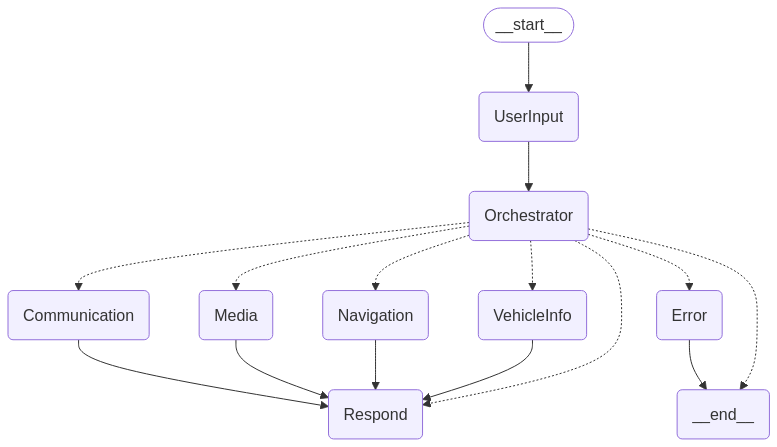

In [11]:
graph_builder = StateGraph(AgentState)

graph_builder.add_node("UserInput", voice_interface_agent)
graph_builder.add_node("Orchestrator", orchestrator_agent)
graph_builder.add_node("Navigation", navigation_node)
graph_builder.add_node("Media", media_node)
graph_builder.add_node("Communication", communication_node)
graph_builder.add_node("VehicleInfo", vehicle_info_node)
graph_builder.add_node("Respond", response_agent)
graph_builder.add_node("Error", error_node)

graph_builder.add_edge(START, "UserInput")
graph_builder.add_edge("UserInput", "Orchestrator")

graph_builder.add_conditional_edges(
    "Orchestrator",
    select_route,
    {
        "Navigation": "Navigation",
        "Media": "Media",
        "Communication": "Communication",
        "VehicleInfo": "VehicleInfo",
        "Respond": "Respond",
        "Error": "Error",
        END: END
    }
)

graph_builder.add_edge("Navigation", "Respond")
graph_builder.add_edge("Media", "Respond")
graph_builder.add_edge("Communication", "Respond")
graph_builder.add_edge("VehicleInfo", "Respond")

graph_builder.add_edge("Error", END)

app_graph = graph_builder.compile()

display(Image(app_graph.get_graph().draw_mermaid_png()))

## Run the Agent System

In [12]:
config = {"recursion_limit": 15}

initial_state = {"messages": [], "final_response_generated": False}

try:
    final_state = app_graph.invoke(initial_state, config=config)
    print("\n--- Interaction Ended ---")
    print("\nFinal State:")
    pprint(final_state)
except Exception as e:
     print(f"\nAn error occurred during execution: {e}")

--- NODE: Voice Interface ---

An error occurred during execution: raw_input was called, but this frontend does not support input requests.
